In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import os
import keras
from keras.preprocessing  import image
from tensorflow.keras.preprocessing import image

import os

from PIL import Image


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input



In [8]:
ref = {"dir_train": r"./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
       "dir_val": r"./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid" }

In [9]:
# preprocess the data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
# lets create our images
training_set = train_datagen.flow_from_directory(ref["dir_train"],
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory(ref["dir_val"],
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')



Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [5]:
def make_model(learning_rate=0.001, size_inner=900, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(target_size, target_size, 3)
    )

    base_model.trainable = False

    #########################################
    inputs = keras.Input(shape=(target_size, target_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
 
    vectors1 = keras.layers.Dense(size_inner , activation='relu')(vectors)
    #vectors2 = keras.layers.Dense(48, activation='relu')(vectors1)
    drop = keras.layers.Dropout(droprate)(vectors1)

    outputs = keras.layers.Dense(38)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [6]:
target_size=224

In [7]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.4f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [9]:
learning_rate = 0.001
size = 900
droprate=0.25
model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

history = model.fit(training_set, epochs=55, validation_data=val_set , callbacks=[checkpoint])


Epoch 1/55
1099/1099 [==============================] - 347s 314ms/step - loss: 0.4822 - accuracy: 0.8506 - val_loss: 0.2628 - val_accuracy: 0.9117
Epoch 2/55
1099/1099 [==============================] - 360s 328ms/step - loss: 0.2407 - accuracy: 0.9195 - val_loss: 0.2146 - val_accuracy: 0.9291
Epoch 3/55
1099/1099 [==============================] - 359s 327ms/step - loss: 0.1932 - accuracy: 0.9348 - val_loss: 0.2308 - val_accuracy: 0.9258
Epoch 4/55
1099/1099 [==============================] - 360s 328ms/step - loss: 0.1606 - accuracy: 0.9451 - val_loss: 0.2112 - val_accuracy: 0.9295
Epoch 5/55
1099/1099 [==============================] - 321s 292ms/step - loss: 0.1384 - accuracy: 0.9526 - val_loss: 0.1785 - val_accuracy: 0.9418
Epoch 6/55
1099/1099 [==============================] - 354s 322ms/step - loss: 0.1281 - accuracy: 0.9562 - val_loss: 0.1648 - val_accuracy: 0.9465
Epoch 7/55
1099/1099 [==============================] - 324s 295ms/step - loss: 0.1112 - accuracy: 0.9614 - val_

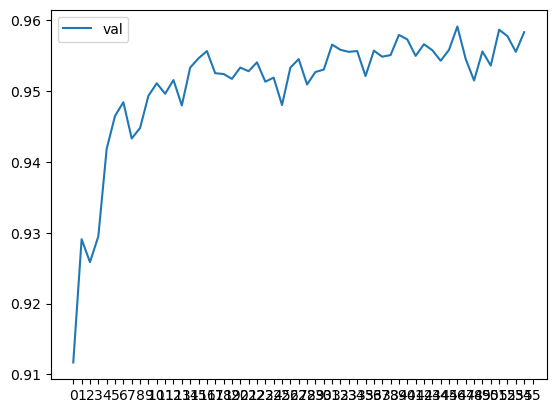

In [11]:
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(56))
plt.legend()

We have increased the # of epocs to 55 to getter a better accuracy, and we got better accuracy score in epoch 47 with score equals to 0.9591. Whave saved the best model, and will load it to use on the testing dataset.

In [7]:
model = keras.models.load_model('xception_v1_47_0.9591.h5')

2022-12-22 13:20:09.642931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:20:09.648907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:20:09.649546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 13:20:09.650462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [13]:
model.evaluate(val_set)

2022-12-22 13:21:30.881743: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-22 13:21:31.524203: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 13:21:31.525006: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 13:21:31.525041: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-22 13:21:31.526043: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 13:21:31.526124: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


275/275 [==============================] - 67s 227ms/step - loss: 0.2722 - accuracy: 0.9591


[0.2721996009349823, 0.9591395258903503]

In [26]:
classes=list(training_set.class_indices.keys())
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [57]:
classes=[i.replace('___',"").replace('_',"") for i in classes]
classes

['AppleApplescab',
 'AppleBlackrot',
 'AppleCedarapplerust',
 'Applehealthy',
 'Blueberryhealthy',
 'Cherry(includingsour)Powderymildew',
 'Cherry(includingsour)healthy',
 'Corn(maize)Cercosporaleafspot Grayleafspot',
 'Corn(maize)Commonrust',
 'Corn(maize)NorthernLeafBlight',
 'Corn(maize)healthy',
 'GrapeBlackrot',
 'GrapeEsca(BlackMeasles)',
 'GrapeLeafblight(IsariopsisLeafSpot)',
 'Grapehealthy',
 'OrangeHaunglongbing(Citrusgreening)',
 'PeachBacterialspot',
 'Peachhealthy',
 'Pepper,bellBacterialspot',
 'Pepper,bellhealthy',
 'PotatoEarlyblight',
 'PotatoLateblight',
 'Potatohealthy',
 'Raspberryhealthy',
 'Soybeanhealthy',
 'SquashPowderymildew',
 'StrawberryLeafscorch',
 'Strawberryhealthy',
 'TomatoBacterialspot',
 'TomatoEarlyblight',
 'TomatoLateblight',
 'TomatoLeafMold',
 'TomatoSeptorialeafspot',
 'TomatoSpidermites Two-spottedspidermite',
 'TomatoTargetSpot',
 'TomatoTomatoYellowLeafCurlVirus',
 'TomatoTomatomosaicvirus',
 'Tomatohealthy']

In [58]:
path="./test/test"
y_test=[ (i.split(".")[0])[:-1] for i in os.listdir(path)]
y_test

['TomatoYellowCurlVirus',
 'TomatoEarlyBlight',
 'TomatoHealthy',
 'CornCommonRust',
 'AppleCedarRust',
 'TomatoHealthy',
 'CornCommonRust',
 'TomatoYellowCurlVirus',
 'TomatoEarlyBlight',
 'PotatoEarlyBlight',
 'AppleCedarRust',
 'TomatoYellowCurlVirus',
 'TomatoYellowCurlVirus',
 'AppleCedarRust',
 'TomatoYellowCurlVirus',
 'AppleScab',
 'TomatoEarlyBlight',
 'TomatoHealthy',
 'TomatoEarlyBlight',
 'TomatoHealthy',
 'PotatoEarlyBlight',
 'PotatoEarlyBlight',
 'CornCommonRust',
 'PotatoHealthy',
 'PotatoHealthy',
 'AppleScab',
 'TomatoEarlyBlight',
 'PotatoEarlyBlight',
 'TomatoEarlyBlight',
 'AppleScab',
 'PotatoEarlyBlight',
 'AppleCedarRust',
 'TomatoYellowCurlVirus']

In [59]:
X_test=[path+"/"+i for i in os.listdir(path)]
X_test

['./test/test/TomatoYellowCurlVirus6.JPG',
 './test/test/TomatoEarlyBlight4.JPG',
 './test/test/TomatoHealthy3.JPG',
 './test/test/CornCommonRust3.JPG',
 './test/test/AppleCedarRust4.JPG',
 './test/test/TomatoHealthy4.JPG',
 './test/test/CornCommonRust2.JPG',
 './test/test/TomatoYellowCurlVirus1.JPG',
 './test/test/TomatoEarlyBlight3.JPG',
 './test/test/PotatoEarlyBlight2.JPG',
 './test/test/AppleCedarRust3.JPG',
 './test/test/TomatoYellowCurlVirus2.JPG',
 './test/test/TomatoYellowCurlVirus5.JPG',
 './test/test/AppleCedarRust2.JPG',
 './test/test/TomatoYellowCurlVirus3.JPG',
 './test/test/AppleScab3.JPG',
 './test/test/TomatoEarlyBlight1.JPG',
 './test/test/TomatoHealthy2.JPG',
 './test/test/TomatoEarlyBlight6.JPG',
 './test/test/TomatoHealthy1.JPG',
 './test/test/PotatoEarlyBlight5.JPG',
 './test/test/PotatoEarlyBlight4.JPG',
 './test/test/CornCommonRust1.JPG',
 './test/test/PotatoHealthy1.JPG',
 './test/test/PotatoHealthy2.JPG',
 './test/test/AppleScab2.JPG',
 './test/test/TomatoEarl

In [63]:
len(X_test)

33

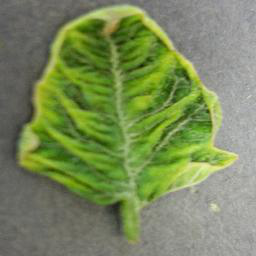

1/1 [==============================] - 0s 20ms/step
 prediction is:  TomatoTomatoYellowLeafCurlVirus >>>>>>>>>>>  correct label is  TomatoYellowCurlVirus




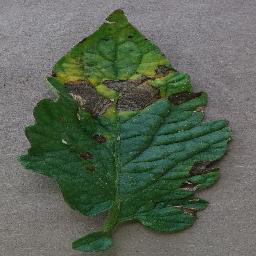

1/1 [==============================] - 0s 22ms/step
 prediction is:  TomatoBacterialspot >>>>>>>>>>>  correct label is  TomatoEarlyBlight




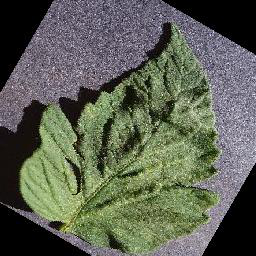

1/1 [==============================] - 0s 20ms/step
 prediction is:  Tomatohealthy >>>>>>>>>>>  correct label is  TomatoHealthy




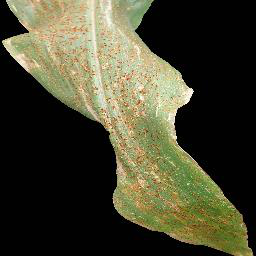

1/1 [==============================] - 0s 21ms/step
 prediction is:  Corn(maize)Commonrust >>>>>>>>>>>  correct label is  CornCommonRust




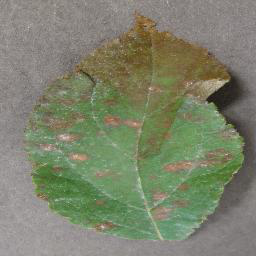

1/1 [==============================] - 0s 20ms/step
 prediction is:  AppleCedarapplerust >>>>>>>>>>>  correct label is  AppleCedarRust




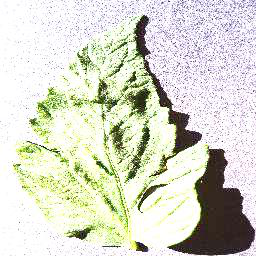

1/1 [==============================] - 0s 20ms/step
 prediction is:  Tomatohealthy >>>>>>>>>>>  correct label is  TomatoHealthy




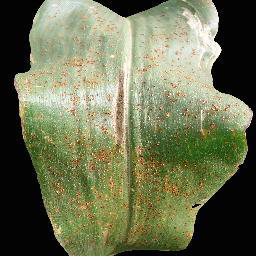

1/1 [==============================] - 0s 20ms/step
 prediction is:  Corn(maize)Commonrust >>>>>>>>>>>  correct label is  CornCommonRust




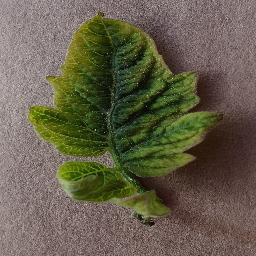

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoTomatoYellowLeafCurlVirus >>>>>>>>>>>  correct label is  TomatoYellowCurlVirus




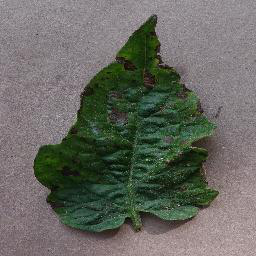

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoEarlyblight >>>>>>>>>>>  correct label is  TomatoEarlyBlight




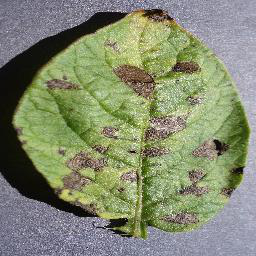

1/1 [==============================] - 0s 22ms/step
 prediction is:  PotatoEarlyblight >>>>>>>>>>>  correct label is  PotatoEarlyBlight




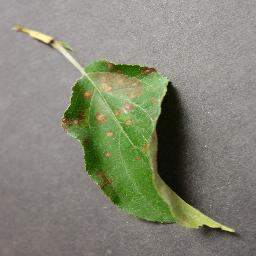

1/1 [==============================] - 0s 20ms/step
 prediction is:  AppleCedarapplerust >>>>>>>>>>>  correct label is  AppleCedarRust




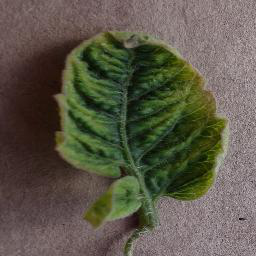

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoTomatoYellowLeafCurlVirus >>>>>>>>>>>  correct label is  TomatoYellowCurlVirus




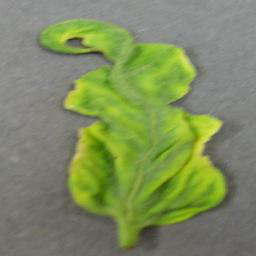

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoTomatoYellowLeafCurlVirus >>>>>>>>>>>  correct label is  TomatoYellowCurlVirus




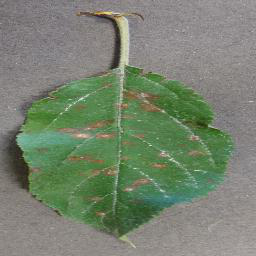

1/1 [==============================] - 0s 21ms/step
 prediction is:  AppleCedarapplerust >>>>>>>>>>>  correct label is  AppleCedarRust




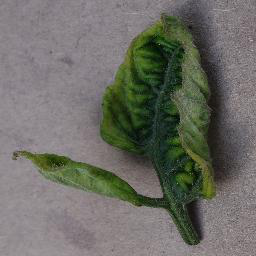

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoLateblight >>>>>>>>>>>  correct label is  TomatoYellowCurlVirus




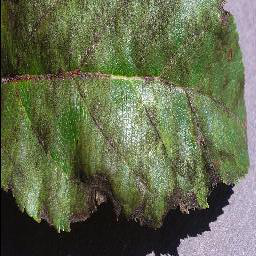

1/1 [==============================] - 0s 22ms/step
 prediction is:  AppleApplescab >>>>>>>>>>>  correct label is  AppleScab




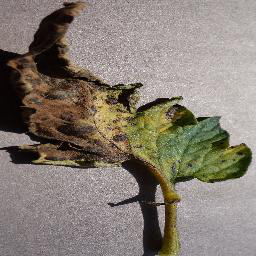

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoEarlyblight >>>>>>>>>>>  correct label is  TomatoEarlyBlight




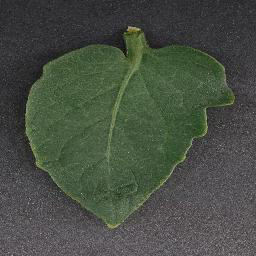

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoTargetSpot >>>>>>>>>>>  correct label is  TomatoHealthy




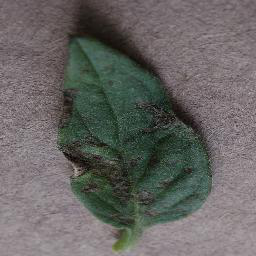

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoEarlyblight >>>>>>>>>>>  correct label is  TomatoEarlyBlight




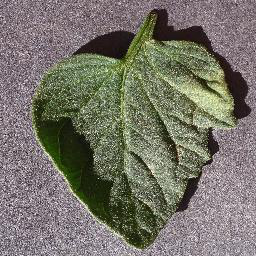

1/1 [==============================] - 0s 21ms/step
 prediction is:  Tomatohealthy >>>>>>>>>>>  correct label is  TomatoHealthy




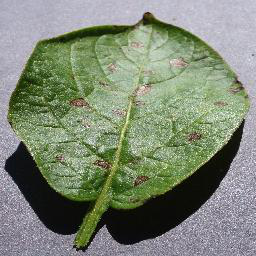

1/1 [==============================] - 0s 21ms/step
 prediction is:  PotatoEarlyblight >>>>>>>>>>>  correct label is  PotatoEarlyBlight




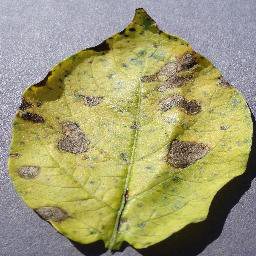

1/1 [==============================] - 0s 21ms/step
 prediction is:  PotatoEarlyblight >>>>>>>>>>>  correct label is  PotatoEarlyBlight




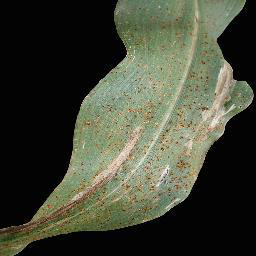

1/1 [==============================] - 0s 21ms/step
 prediction is:  Corn(maize)Commonrust >>>>>>>>>>>  correct label is  CornCommonRust




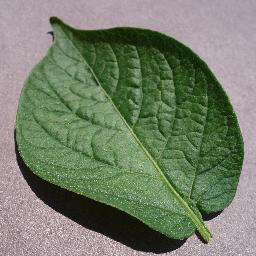

1/1 [==============================] - 0s 22ms/step
 prediction is:  Potatohealthy >>>>>>>>>>>  correct label is  PotatoHealthy




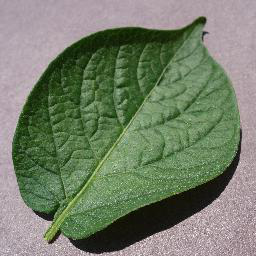

1/1 [==============================] - 0s 21ms/step
 prediction is:  Potatohealthy >>>>>>>>>>>  correct label is  PotatoHealthy




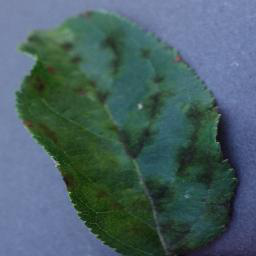

1/1 [==============================] - 0s 21ms/step
 prediction is:  AppleApplescab >>>>>>>>>>>  correct label is  AppleScab




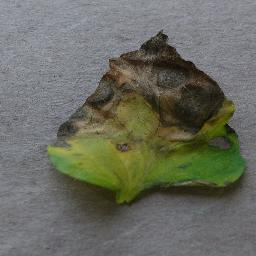

1/1 [==============================] - 0s 22ms/step
 prediction is:  TomatoEarlyblight >>>>>>>>>>>  correct label is  TomatoEarlyBlight




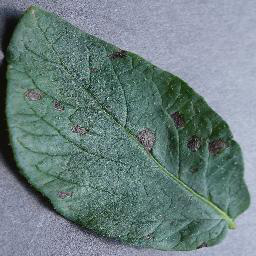

1/1 [==============================] - 0s 20ms/step
 prediction is:  PotatoEarlyblight >>>>>>>>>>>  correct label is  PotatoEarlyBlight




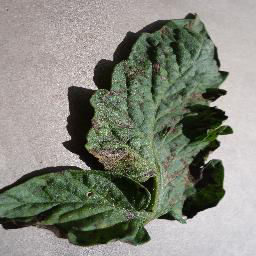

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoSeptorialeafspot >>>>>>>>>>>  correct label is  TomatoEarlyBlight




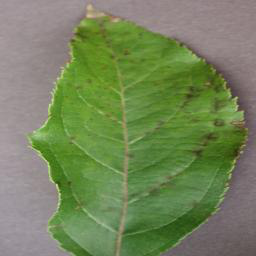

1/1 [==============================] - 0s 20ms/step
 prediction is:  AppleApplescab >>>>>>>>>>>  correct label is  AppleScab




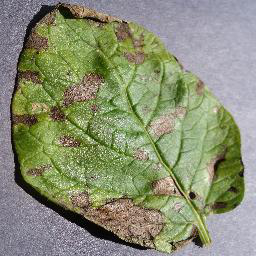

1/1 [==============================] - 0s 21ms/step
 prediction is:  PotatoEarlyblight >>>>>>>>>>>  correct label is  PotatoEarlyBlight




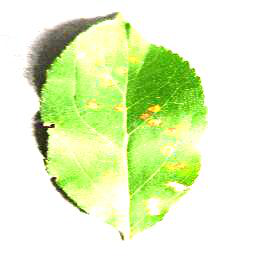

1/1 [==============================] - 0s 22ms/step
 prediction is:  AppleCedarapplerust >>>>>>>>>>>  correct label is  AppleCedarRust




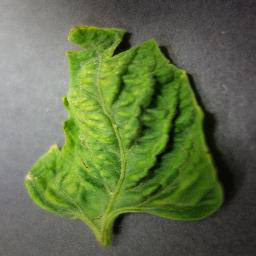

1/1 [==============================] - 0s 21ms/step
 prediction is:  TomatoTomatoYellowLeafCurlVirus >>>>>>>>>>>  correct label is  TomatoYellowCurlVirus




In [61]:
 
for m, i in enumerate(X_test):
    im = Image.open(i)
    im.show()
    img = load_img(i,target_size=(224,224))
      
    x = np.array(img)
    X = np.array([x])
    X = preprocess_input(X)
    pred = model.predict(X)
    indx=np.argmax(pred)
    
    print(" prediction is: ", classes[indx], ">>>>>>>>>>>", " correct label is ",y_test[m])
    print()
    print()



##### Out of 33 images, our model pridected  29 images correctly & misclassifed 4 images.